#**Procedimiento para análisis de plagas**


##**Definición del problema**

**Objetivo:** Predecir el nivel de riesgo de plaga para el próximo mes utilizando datos de los 6 meses previos. En esta etapa se define claramente el problema y qué datos se requieren. Por ejemplo, podría tratarse de predecir el número de insectos/plagas esperados en un cultivo el mes siguiente, basándose en factores históricos como clima, humedad, tratamientos, etc. Es importante identificar qué variables influyen en el riesgo de plaga (temperatura, precipitación, humedad, tipo de cultivo, incidencias de plaga observadas, etc.) y cómo obtener esos datos. También es posible predecir datos de producción basados en la información previa.

###**Carga de datos y construcción del DataFrame**

In [1]:
# ===== Bloque 0: Imports y config =====
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance

from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [43]:
import pandas as pd

# 1) URL RAW correcta
RAW_URL = "https://raw.githubusercontent.com/Da-Pe-Al/Analisis-de-plagas/main/plagas_sintetico_5000.csv"

# 2) Cargar CSV
df = pd.read_csv(RAW_URL, encoding="utf-8-sig")

# 3) Normalizar nombres
df = df.rename(columns={
    "TemperaturaPromedio (°C)": "Temp",
    "Precipitación (mm)": "Prec",
    "IncidenciaPlaga": "plaga",
})

# 4) Asegurar 'Mes' como datetime mensual (si viene tipo 'YYYY-MM')
if "Mes" in df.columns:
    df["Mes"] = pd.to_datetime(df["Mes"], format="%Y-%m", errors="coerce")
elif "Fecha" in df.columns:
    df["Mes"] = pd.to_datetime(df["Fecha"], errors="coerce").dt.to_period("M").dt.to_timestamp("S")
else:
    raise ValueError("No encuentro columna temporal ('Mes' o 'Fecha').")

# 5) Tipos numéricos seguros
df["Temp"]  = pd.to_numeric(df["Temp"], errors="coerce")
df["Prec"]  = pd.to_numeric(df["Prec"], errors="coerce")
df["plaga"] = pd.to_numeric(df["plaga"], errors="coerce").astype("Int64")  # usa int64 si no hay NA

# 6) Orden temporal
df = df.sort_values("Mes").reset_index(drop=True)

# 7) Asegura datetime
df["Mes"] = pd.to_datetime(df["Mes"], format="%Y-%m", errors="coerce")

# 8) Resample mensual
df = (df.set_index("Mes")
        .resample("MS")
        .agg({
            "Temp": "mean",
            "Prec": "sum",
            "plaga": "mean"
        })
        .reset_index())
df.rename(columns={"Mes": "MesLabel"}, inplace=True)

print(df.head())
print(df.dtypes)


    MesLabel       Temp    Prec     plaga
0 2019-01-01  17.649643  1513.7  0.821429
1 2019-02-01  19.032642  1457.9  1.754717
2 2019-03-01  20.794800  1333.5      2.56
3 2019-04-01  23.672308  2707.8  4.815385
4 2019-05-01  25.820968  3636.2  5.758065
MesLabel    datetime64[ns]
Temp               float64
Prec               float64
plaga              Float64
dtype: object


### **Preprocesamiento y Normalización**

In [45]:
# Extrae mes (1..12) desde MesLabel
def extract_month_col(X: pd.DataFrame) -> pd.DataFrame:
    m = pd.to_datetime(X['MesLabel']).dt.month.to_frame(name='month')
    return m

month_extractor = FunctionTransformer(extract_month_col, validate=False)

# Aplica log1p SOLO a Prec; Temp pasa tal cual; luego escalar ambas
log_prec = ColumnTransformer(
    transformers=[
        ('prec_log', FunctionTransformer(np.log1p, validate=False), ['Prec']),
        ('temp_passthrough', 'passthrough', ['Temp'])
    ],
    remainder='drop'
)

num_scaled = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_prec', log_prec),
    ('scale', StandardScaler())
])

time_pipe = Pipeline(steps=[
    ('month', month_extractor),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_scaled, ['Temp','Prec']),
        ('time', time_pipe, ['MesLabel']),
    ],
    remainder='drop'
)


###**Análisis exploratorio de los Datos**

            Temp          Prec      plaga
count  84.000000     84.000000       84.0
mean   22.985722   4824.352381   4.972127
std     3.425719   3435.721299   2.989443
min    17.649643   1048.600000   0.821429
25%    19.647083   2105.275000   2.233333
50%    23.469842   3131.400000   4.797523
75%    26.326866   8136.350000   8.208333
max    27.723226  13429.900000  10.465517


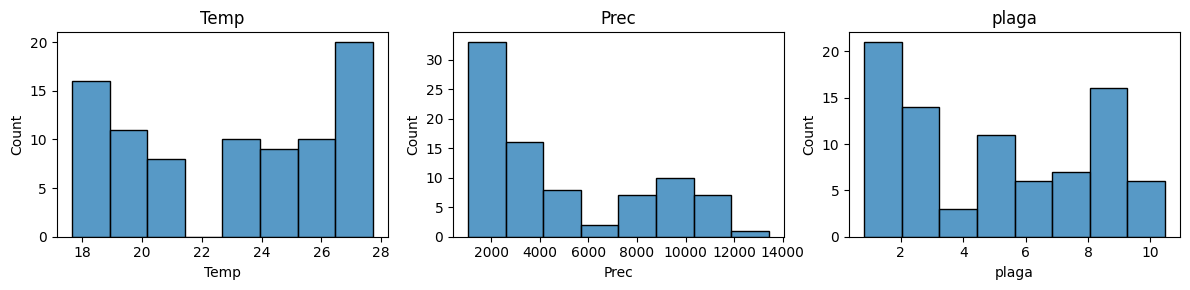

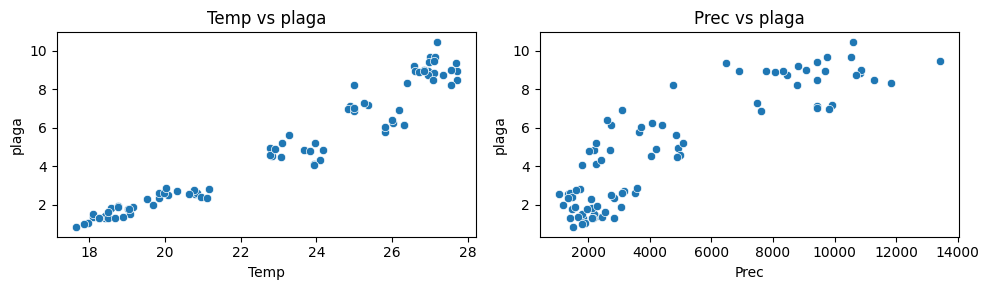

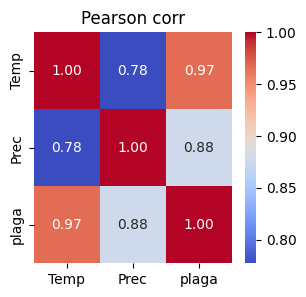

In [46]:
# ===== Bloque 3: EDA rápida =====
print(df[['Temp','Prec','plaga']].describe())

# Distribuciones
fig, axes = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(df['Temp'], ax=axes[0]); axes[0].set_title('Temp')
sns.histplot(df['Prec'], ax=axes[1]); axes[1].set_title('Prec')
sns.histplot(df['plaga'], ax=axes[2]); axes[2].set_title('plaga')
plt.tight_layout(); plt.show()

# Relación con target
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sns.scatterplot(x='Temp', y='plaga', data=df, ax=axes[0]); axes[0].set_title('Temp vs plaga')
sns.scatterplot(x='Prec', y='plaga', data=df, ax=axes[1]); axes[1].set_title('Prec vs plaga')
plt.tight_layout(); plt.show()

# Correlación (Pearson)
corr = df[['Temp','Prec','plaga']].corr(method='pearson')
plt.figure(figsize=(3.2,3))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Pearson corr'); plt.show()
